## Housing, Health & Happiness - Creative Extension

### I. Importing Libraries and Data

In [5]:
### Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas.util.testing as tm
import seaborn as sns

### Import data

DATA_FOLDER = 'Data/'

# NaN values are replaced with 0, as described in the paper 
# SHOULD WE DROP NaN VALUES OR PUT THEM TO 0 ? IT CHANGES THE VALUE FOR THE MEAN !!

household_data = pd.read_stata(DATA_FOLDER + 'PisoFirme_AEJPol-20070024_household.dta').dropna()
individual_data = pd.read_stata(DATA_FOLDER + 'PisoFirme_AEJPol-20070024_individual.dta').dropna()

In [6]:
household_data

dpisofirme    idcluster     coord_x    coord_y  idmun  idmza  \
0            0.0   70000537.0 -103.503670  25.583067    7.0     40   
3            0.0   70000537.0 -103.503670  25.583067    7.0     47   
4            0.0   70000537.0 -103.503670  25.583067    7.0     47   
5            0.0   70000537.0 -103.503670  25.583067    7.0     41   
8            0.0   70000679.0 -103.489845  25.578873    7.0     34   
...          ...          ...         ...        ...    ...    ...   
2749         1.0  353150000.0 -103.399841  25.501871   35.0     36   
2750         1.0  353150000.0 -103.399841  25.501871   35.0     40   
2752         1.0  353150000.0 -103.399841  25.501871   35.0     35   
2753         1.0  353150000.0 -103.399841  25.501871   35.0     34   
2754         1.0  353220000.0 -103.454765  25.519363   35.0      2   

      C_blocksdirtfloor  C_HHdirtfloor  C_child05  C_households  ...  S_cesds  \
0              0.300000       0.036629   0.555554         819.0  ...     14.0   
3              0.300000       0.036629   0.555554         819.0  ...     20.0   
4              0.300000       0.036629   0.555554         819.0  ...      4.0   
5              0.300000       0.036629   0.555554         819.0  ...     25.0   
8              0.266667       0.030579   0.654435         327.0  ...     16.0   
...                 ...            ...        ...           ...  ...      ...   
2749           0.538462       0.100774   0.759924         454.0  ...     21.0   
2750           0.538462       0.100774   0.759924         454.0  ...     19.0   
2752           0.538462       0.100774   0.759924         454.0  ...     12.0   
2753           0.538462       0.100774   0.759924         454.0  ...      6.0   
2754           0.833333       0.354845   1.000010          31.0  ...     19.0   

      S_pss  S_instcement  S_instsanita  S_restsanita  S_constceili  \
0      12.0           0.0           0.0           0.0           0.0   
3      19.0           0.0           0.0           0.0           0.0   
4       5.0           0.0           0.0           0.0           0.0   
5      26.0           0.0           0.0           0.0           0.0   
8      19.0           1.0           0.0           1.0           0.0   
...     ...           ...           ...           ...           ...   
2749   19.0           1.0           0.0           0.0           0.0   
2750   20.0           1.0           0.0           0.0           1.0   
2752   19.0           1.0           0.0           0.0           0.0   
2753   10.0           1.0           0.0           0.0           0.0   
2754   20.0           1.0           0.0           0.0           0.0   

      S_restowalls  S_improveany  S_logrent  S_logsell  
0              0.0           0.0   5.298317   9.903487  
3              0.0           0.0  11.385092  11.918390  
4              0.0           0.0   5.703783  10.819778  
5              0.0           0.0   4.605170   8.517193  
8              0.0           1.0   7.313221  11.512925  
...            ...           ...        ...        ...  
2749           0.0           0.0   5.857933  10.463103  
2750           0.0           1.0   5.298317   9.615806  
2752           0.0           0.0   5.991465   9.210340  
2753           0.0           0.0   6.396930  11.918390  
2754           0.0           0.0   5.298317   9.903487  

[1953 rows x 78 columns]

### II. Is the original matching truly balanced ? 

> In the paper 'Housing, Health, and Happiness', the treatment and control group are matched according to the variables C_blockdirtfloor, C_HHdirtfloor, C_child05 and C_households. The paper claims that these 4 variables are balances, according to Table 2 where the means for treatment and control are computed, along with standard errors and the mean difference. Let us verify with statistical tests that this is indeed the case.  

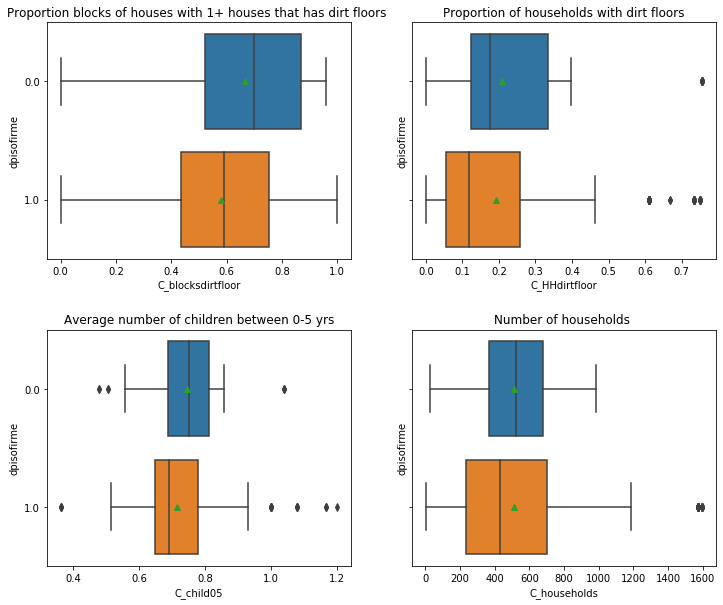

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
fig.subplots_adjust(hspace=0.3)

sns.boxplot(ax=axes[0,0], x=household_data['C_blocksdirtfloor'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[0,0].set_title('Proportion blocks of houses with 1+ houses that has dirt floors ')

sns.boxplot(ax=axes[0,1], x=household_data['C_HHdirtfloor'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[0,1].set_title('Proportion of households with dirt floors');

sns.boxplot(ax=axes[1,0], x=household_data['C_child05'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[1,0].set_title('Average number of children between 0-5 yrs');

sns.boxplot(ax=axes[1,1], x=household_data['C_households'], y=household_data['dpisofirme'], showmeans=True, orient='h');
axes[1,1].set_title('Number of households ');

In [8]:
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import levene
from scipy.stats import ttest_ind

# Levene test verifies the null hypothesis that all input samples are from populations with equal variances.

# The t-test verifies the null hypothesis that 2 independent samples have identical average (expected) values. 
# This test assumes that the populations have identical variances by default, but we define as False if the 
# variances are not equal (known as Welch's t-test). 

df = pd.DataFrame(columns = household_data.columns).reset_index()
df['index'] = ['Levene test', 'T-test', 'Identical Mean']

for col in household_data:
    
    a = household_data[col][household_data['dpisofirme'] == 1]
    b = household_data[col][household_data['dpisofirme'] == 0]
    ltest = levene(a,b)
    if (ltest.pvalue < 0.05):
        ttest = ttest_ind(a, b, equal_var = False)
    else:
        ttest = ttest_ind(a, b, equal_var = True)
    if (ttest.pvalue < 0.05):
        identical_mean = False
    else:
        identical_mean = True
        
    df[col] = pd.Series([ltest.pvalue, ttest.pvalue, identical_mean])
    
df = df.drop(df.columns[[1, 2, 3, 4, 5, 6]], axis = 1)
df

index C_blocksdirtfloor C_HHdirtfloor    C_child05 C_households  \
0     Levene test        0.00815607   9.87166e-09  0.000830479  2.51441e-29   
1          T-test       4.53646e-18     0.0144944  1.70607e-12     0.988007   
2  Identical Mean             False         False        False         True   

      C_people      C_rooms  C_HHpersons  C_waterland C_waterhouse  ...  \
0  6.18206e-32  9.17264e-05  2.04649e-14  1.90158e-09  1.04218e-17  ...   
1     0.400063    0.0134354  3.71459e-23  3.34897e-16  8.71024e-11  ...   
2         True        False        False        False        False  ...   

       S_cesds        S_pss S_instcement S_instsanita S_restsanita  \
0  2.38332e-05     0.202926  1.99315e-76     0.512832     0.824155   
1  1.79029e-07  5.00082e-07  4.12629e-78     0.512832     0.824155   
2        False        False        False         True         True   

  S_constceili S_restowalls S_improveany S_logrent S_logsell  
0     0.341964     0.411424    0.0644686  0.464456  0.310781  
1     0.341964     0.411424    0.0644686   0.33917  0.599814  
2         True         True         True      True      True  

[3 rows x 73 columns]

> It appears that the mean values for the 4 variables used for the matching are not balanced, as the statistical test yields a p-value below the threshold of 0.05, indicating that we must reject the null hypothesis of equal averages.

In [9]:
# Looking at the mean values 
np.mean(household_data['C_blocksdirtfloor'][household_data['dpisofirme'] == 1])

0.5804550051689148

### III. Benchmarking
> Omitted variable bias can affect treatment effect estimates obtained from observational data due to the lack of random assignment to treatment groups. Sensitivity analyses adjust these estimates to quantify the impact of potential omitted variables.
> As a first step of sensitivity analysis, one can use benchmarking: the use of data to establish reference points for speculation about omitted confounders.

In [77]:
### Creating a Dataframe for the data

R2_df = pd.DataFrame(columns = ['Total Model 3', 'C(dpisofirme)', 'S_HHpeople', 'S_headage','S_spouseage','S_headeduc',\
                                'S_spouseeduc', 'S_dem1','S_dem2','S_dem3','S_dem4','S_dem5','S_dem6','S_dem7','S_dem8',\
                                'C(S_waterland)','C(S_waterhouse)','C(S_electricity)','C(S_hasanimals)','C(S_animalsinside)',\
                                'C(S_garbage)', 'S_washhands', 'S_cashtransfers', 'C(S_milkprogram)', 'C(S_foodprogram)',\
                                'C(S_seguropopular)']).reset_index()
R2_df['index'] = ['Share of rooms with cement floors', 'Cement floor in kitchen',\
                  'Cement floor in dining room', 'Cement floor in bathroom', 'Cement floor in bedroom']

In [78]:
def create_mod_str(x,z):
    output_str = ''
    for i in range(0,len(x)):
        if((i != z) and (i != len(x)-1)):
            output_str = output_str + x[i] + ' + '
        if(i == len(x)-1):
            output_str = output_str + x[i]
    return output_str

In [108]:
### Omitted variable bias 

# We begin by looking at the effect of regressors on R^2. We can look at each variable of the models and see 
# the change incurred in R^2 when the regressors are not included in the model. This enables a classification 
# of the most predictive regressors in terms of R^2. Indeed, the difference in R^2 corresponds to the bias 
# that would have been incurred by omitting said variable in the model. 

# Looking at Model 3 for Table 4 of the paper
mod_variables = ['S_shcementfloor', 'S_cementfloorkit', 'S_cementfloordin', 'S_cementfloorbat', 'S_cementfloorbed']
mod_regressors = ['C(dpisofirme)', 'S_HHpeople', 'S_headage','S_spouseage','S_headeduc',\
                  'S_spouseeduc', 'S_dem1','S_dem2','S_dem3','S_dem4','S_dem5','S_dem6','S_dem7','S_dem8',\
                  'C(S_waterland)','C(S_waterhouse)','C(S_electricity)','C(S_hasanimals)','C(S_animalsinside)',\
                  'C(S_garbage)', 'S_washhands', 'S_cashtransfers', 'C(S_milkprogram)', 'C(S_foodprogram)',\
                  'C(S_seguropopular)']
model3 = 'C(dpisofirme) + S_HHpeople + S_headage + S_spouseage + \
                     S_headeduc + S_spouseeduc + S_dem1 + S_dem2 + S_dem3 + S_dem4 + S_dem5 + S_dem6 + S_dem7 \
                     + S_dem8 + C(S_waterland) + C(S_waterhouse) + C(S_electricity) + C(S_hasanimals) + \
                     C(S_animalsinside) + C(S_garbage) + S_washhands + S_cashtransfers + C(S_milkprogram) +\
                     C(S_foodprogram) + C(S_seguropopular)'

for i in range(0,5):
    
    # Declaring Model
    mod = smf.ols(formula = mod_variables[i] + ' ~ ' + model3, data = household_data)

    # Fitting Model
    np.random.seed(2)
    res = mod.fit(cov_type = 'cluster', cov_kwds={'groups': household_data['idcluster']})
    R2 = res.rsquared
    R2_df['Total Model 3'].iloc[i] = R2
    
    for j in range(len(mod_regressors)):
    
        # Declaring the Model
        mod = smf.ols(formula = mod_variables[i] + ' ~ ' + create_mod_str(mod_regressors,j), data = household_data)

        # Fitting Model
        np.random.seed(2)
        res = mod.fit(cov_type = 'cluster', cov_kwds={'groups': household_data['idcluster']})
        R2 = res.rsquared
        R2_df[mod_regressors[j]].iloc[i] = 100*((1-np.square(R2_df['Total Model 3'].iloc[i]))-(1-np.square(R2)))/(1-np.square(R2_df['Total Model 3'].iloc[i]))

R2_df

index Total Model 3 C(dpisofirme)   S_HHpeople  \
0  Share of rooms with cement floors      0.191436      -2.96818   -0.0447491   
1            Cement floor in kitchen      0.160218      -2.13668   -0.0413046   
2        Cement floor in dining room      0.121382      -1.12876    -0.018162   
3           Cement floor in bathroom      0.103935     -0.408815 -0.000977321   
4            Cement floor in bedroom      0.128028      -1.29014     -0.21216   

    S_headage  S_spouseage S_headeduc S_spouseeduc      S_dem1      S_dem2  \
0 -0.00565333   -0.0373261  -0.268815   -0.0450121  -0.0585467  -0.0585467   
1  -0.0279237   -0.0229414  -0.227514  -0.00570243  -0.0383991  -0.0383991   
2  -0.0095364   -0.0203053  -0.156338 -6.17223e-05 -0.00933973 -0.00933972   
3 -0.00441375 -7.07171e-05  -0.051058   -0.0595394  -0.0217058  -0.0217058   
4  -0.0159348   -0.0367581   -0.15358  -0.00731602  -0.0379619  -0.0379619   

   ... C(S_waterhouse) C(S_electricity) C(S_hasanimals) C(S_animalsinside)  \
0  ...       -0.996791       -0.0131407    -0.000110957         -0.0970336   
1  ...       -0.505653      -0.00311954      -0.0213569         -0.0852746   
2  ...       -0.466036     -1.53841e-05      -0.0279397        -0.00484339   
3  ...       -0.408903       -0.0371074      -0.0395231         -0.0260611   
4  ...       -0.167057       -0.0051843     -0.00394761          -0.068713   

  C(S_garbage) S_washhands S_cashtransfers C(S_milkprogram) C(S_foodprogram)  \
0  -0.00739002  -0.0768083       -0.123158      -0.00443578       -0.0456003   
1  -0.00471999   -0.127004       -0.126766     -8.62792e-05       -0.0373887   
2  -0.00263837   -0.009657        -0.11047      -0.00414518       -0.0783204   
3    -0.154316  -0.0537912      -0.0188222        -0.024122       -0.0262373   
4  -0.00124204 -0.00475056     -0.00219662        -0.002917     -0.000230521   

  C(S_seguropopular)  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 27 columns]

### IV. Propensity score matching
> To remedy the matching issues, one can use the propensity score in order to match treatment and control groups.

In [4]:
### Defining the formulas for the regression models (LHS and RHS)

# LHS represents the 5 studied variables

mod_formula_lhs = ['S_shcementfloor', 'S_cementfloorkit', 'S_cementfloordin', 'S_cementfloorbat', 'S_cementfloorbed']

# RHS represents the control variables for the 3 models
  # Model 1: no controls
  # Model 2: age, demographic, health habits controls
  # Model 3: age, demographic, health habits, and public social programs controls

mod_formula_rhs = ['C(dpisofirme)', 'C(dpisofirme) + S_HHpeople + S_headage + S_spouseage + \
                     S_headeduc + S_spouseeduc + S_dem1 + S_dem2 + S_dem3 + S_dem4 + S_dem5 + S_dem6 + S_dem7 \
                     + S_dem8 + C(S_waterland) + C(S_waterhouse) + C(S_electricity) + C(S_hasanimals) + \
                     C(S_animalsinside) + C(S_garbage) + S_washhands', 'C(dpisofirme) + S_HHpeople + S_headage + S_spouseage + \
                     S_headeduc + S_spouseeduc + S_dem1 + S_dem2 + S_dem3 + S_dem4 + S_dem5 + S_dem6 + S_dem7 \
                     + S_dem8 + C(S_waterland) + C(S_waterhouse) + C(S_electricity) + C(S_hasanimals) + \
                     C(S_animalsinside) + C(S_garbage) + S_washhands + S_cashtransfers + C(S_milkprogram) +\
                     C(S_foodprogram) + C(S_seguropopular)'] 

# N.B. : the variable S_rooms is not included (number of rooms in the house), as it was not included in the Stata code
# provided. The variable is said to be used in the Models 2 and 3 in the paper, but the regressions yield better results
# in terms of replication when it is not included. 

In [5]:
### Declare Model

mod = smf.ols(formula = mod_formula_lhs[1] + ' ~ ' + mod_formula_rhs[1], data=household_data)

### Fit Model

np.random.seed(2)
res = mod.fit()

### Propensity score

household_data['Propensity_score'] = res.predict()   

In [6]:
len(household_data['Propensity_score'].unique())

2782